### A notebook to normalize the orientation of the centriole 

This normalization occur on a data_Laoder

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import numpy as np
import csv
import pickle
import import_ipynb

import random

In [2]:
def dataset_loader(path = '../data/', train_set = 'train_data_pregression_b700_unNormalized.pth', val_set = 'validation_loader_dataset_b700_unNormalized.pth' ):
    """ A function that load a 'torch' dataset.
    Arguments:
        -> path    : path to the dataset location
        -> train_set: name of the train dataset
        -> val_set  : name of the validation dataset
    """
    train_loader = pickle.load(open(path + train_set, 'rb'))
    validation_loader = pickle.load(open(path + val_set, 'rb'))
    
    return train_loader, validation_loader

In [3]:
class centriole_dataset(Dataset):
    def __init__(self, img_db, angle_db, transform = None, root_dir = None, problem = None):
        self.root_dir = root_dir
        self.img_db = img_db
        self.angle_db = angle_db
        self.transform = transform
        self.problem = problem
           
    def __len__(self):
        return len(self.angle_db)
    
    def __getitem__(self, idx):
        
        img = self.img_db[idx]
        angle = self.angle_db[idx]
        
        if self.problem == 'classification':
            angle = np.array(angle, dtype = 'int') # [angle]
        else:
            angle = np.array(angle, dtype = 'double')
        
        sample = {'image': img, 'angle': angle}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [4]:
train_loaded = pickle.load(open('./data/train_data_pregression_b700_unNormalized.pth', 'rb'))

importing Jupyter notebook from /home/cyril_b/projects/Planarians/tools/Dataset_Tools.ipynb
importing Jupyter notebook from /home/cyril_b/projects/Planarians/tools/ToolBox.ipynb


In [14]:
img_db = []
angle_db = []
maxAngle = 0

for data in train_loaded:
    for i in range(len(data['angle'])):
        # Search the number of 90 deg rotation to put the centriole in an 0-90° range
        rotation = (data['angle'][i].numpy()//72)//18*90
        newAngle = data['angle'][i].numpy()-rotation
        
        if data['angle'][i] > maxAngle:
            maxAngle = data['angle'][i]
            print(maxAngle)
        
        
        # Re orient the image in a 0-90° range
        i = 0
        image = data['image'][i].numpy()
        while i != rotation:
            image = np.rot90(image)
            i += 1
        
        # Randomly reorient the image and adjust the angle
        i = 0
        rd_rot = random.randint(0,3)
        while i != rd_rot:
            image = np.rot90(image)
            newAngle -= 90
            if newAngle < 0:
                newAngle = 360 + newAngle
            i += 1
        
        if newAngle//5 == 0 or newAngle//5 == 18 or newAngle//5 == 36 or newAngle//5 == 54:
            if random.random() < 0.66:
                
                img_db.append(image)
                angle_db.append(newAngle)
        else: 
            img_db.append(image)
            angle_db.append(newAngle)

print('Computation over')

tensor(291.2519, dtype=torch.float64)
tensor(354.9565, dtype=torch.float64)
tensor(355.9145, dtype=torch.float64)
tensor(357.1376, dtype=torch.float64)
tensor(357.3975, dtype=torch.float64)
tensor(357.3980, dtype=torch.float64)
tensor(358.2101, dtype=torch.float64)
tensor(358.5679, dtype=torch.float64)
tensor(358.5682, dtype=torch.float64)
tensor(358.6361, dtype=torch.float64)
tensor(358.6678, dtype=torch.float64)
tensor(359.0285, dtype=torch.float64)
tensor(359.2258, dtype=torch.float64)
tensor(359.2462, dtype=torch.float64)
tensor(359.3097, dtype=torch.float64)
tensor(359.3634, dtype=torch.float64)
tensor(359.4569, dtype=torch.float64)
Computation over


In [15]:
newDB = []

for i in img_db:
    flat = i.flatten()
    flat = flat.reshape(1,32,32)
    newDB.append(flat)
    
newDB = np.array(newDB, dtype='double')
newDB = newDB.reshape(len(img_db), 1, 32, 32)

In [16]:
angle_db = np.array(angle_db)

training = centriole_dataset(newDB, angle_db, problem = 'regression')

train_loader = torch.utils.data.DataLoader(training, batch_size = 700, shuffle = True, drop_last=True)

In [18]:
pickle.dump(train_loader, open('./data/data_train_regression_normalized.pth', 'wb'), protocol=4)

<AxesSubplot:ylabel='Count'>

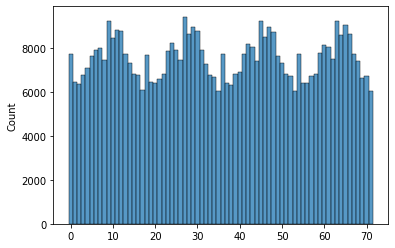

In [17]:
class_72 = np.zeros(72)
classes = np.linspace(0,71, 72, dtype = np.int16)

for i in train_loader:
    for j in i['angle']:
        class_72[int(j.numpy()//5)] += 1
        
import seaborn as sns

sns.histplot(x = classes, weights = class_72, discrete =  True)

<AxesSubplot:ylabel='Count'>

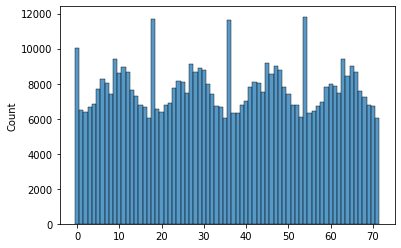

In [80]:
class_72 = np.zeros(72)
classes = np.linspace(0,71, 72, dtype = np.int16)

for i in train_loader:
    for j in i['angle']:
        class_72[int(j.numpy()//5)] += 1
        
import seaborn as sns

sns.histplot(x = classes, weights = class_72, discrete =  True)

In [70]:
max(class_72)/(sum(class_72)/72)


1.5209726443768996